In [2]:
import gzip
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import os
import random

import imn_loading

In [3]:
def read_poi_data(filepath):
    poi_data = {}
    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            # Keep UID as int to match IMN data format
            poi_data[row['uid']] = row
    return poi_data

poi_to_activity = {
    "education": "school", "food_and_drink": "eat", "shopping": "shop",
    "entertainment_and_recreation": "leisure", "transportation": "transit",
    "healthcare": "health", "public_services": "admin", "finance": "finance",
    "utilities": "utility", "other": "unknown"
}

def enrich_imn_with_poi(imn, poi_info):
    poi_classes = poi_info["poi_classes"]
    enriched = {}
    for loc_id, loc in imn["locations"].items():
        vec = poi_info["poi_freq"].get(loc_id, [0.0]*len(poi_classes))
        top_idx = int(np.argmax(vec))
        label = poi_to_activity.get(poi_classes[top_idx], "unknown")
        if loc_id == imn.get("home"): label = "home"
        if loc_id == imn.get("work"): label = "work"
        enriched[loc_id] = {**loc, "activity_label": label}
    imn["locations"] = enriched
    return imn

def extract_stays_from_trips(trips, locations):
    """Convert trips into stays by considering the destination of each trip as a stay."""
    stays = []
    
    # First pass: create stays with start times
    for from_id, to_id, st, et in trips:
        activity_label = locations[to_id].get('activity_label', 'unknown')
        # Create stay with start time as trip end time
        stays.append(Stay(to_id, activity_label, et, None))
    
    # Second pass: set end times based on next stay's start time
    for i in range(len(stays)-1):
        # set end time to the START of the next trip, not the next stay's start
        next_trip_start = trips[i+1][2]  # start time of the next trip
        stays[i].set_end_time(next_trip_start)
    
    # Handle the last stay
    if stays:
        # For the last stay, if there's a next day's first trip, use that as end time
        # Otherwise, use a default duration of 1 hour
        last_stay = stays[-1]
        if last_stay.start_time is not None:
            last_stay.set_end_time(last_stay.start_time + 3600)  # Default 1 hour duration
    
    return stays

def extract_stays_by_day(stays):
    """Group stays by day, handling cross-day stays."""
    stays_by_day = defaultdict(list)
    
    for stay in stays:
        if stay.start_time is None or stay.end_time is None:
            continue
            
        start_dt = datetime.fromtimestamp(stay.start_time, tz)
        end_dt = datetime.fromtimestamp(stay.end_time, tz)
        
        # If stay spans multiple days, split it
        current_dt = start_dt.replace(hour=0, minute=0, second=0, microsecond=0)
        end_of_day = current_dt + timedelta(days=1)
        
        while current_dt < end_dt:
            day_start = max(start_dt, current_dt)
            day_end = min(end_dt, end_of_day)
            
            # Create stay for this day
            day_stay = Stay(
                stay.location_id,
                stay.activity_label,
                int(day_start.timestamp()),
                int(day_end.timestamp())
            )
            
            stays_by_day[current_dt.date()].append(day_stay)
            
            # Move to next day
            current_dt = end_of_day
            end_of_day = current_dt + timedelta(days=1)
    
    return stays_by_day


class Stay:
    def __init__(self, location_id, activity_label, start_time, end_time):
        self.location_id = location_id
        self.activity_label = activity_label
        self.start_time = start_time
        self.end_time = end_time
        self.duration = self.end_time - self.start_time if self.end_time is not None and self.start_time is not None else None

    def set_end_time(self, end_time):
        self.end_time = end_time
        if self.start_time is not None:
            self.duration = self.end_time - self.start_time

    def to_dict(self):
        return {
            'location_id': self.location_id,
            'activity_label': self.activity_label,
            'start_time': self.start_time,
            'end_time': self.end_time,
            'duration': self.duration
        }

In [4]:
# Load IMNs and POI data from the new test files
#imns = imn_loading.read_imn('data/test_milano_imns.json.gz')

imns = imn_loading.read_imn('data/milano_2007_imns.json.gz')
filtered_user_ids = list(imns.keys())
imns = imn_loading.read_imn('data/test_milano_imns.json.gz')
# in the imns I want to keep those with keys in filtered_user_ids
imns = {k: imns[k] for k in filtered_user_ids}

poi_data = read_poi_data('data/test_milano_imns_pois.json.gz')
print(f"Loaded {len(imns)} IMNs and POI data for {len(poi_data)} users")

Loaded 248 IMNs and POI data for 11658 users


In [5]:
user_id = 650

In [6]:
imn = imns[user_id]
imn.keys()

dict_keys(['locations', 'trips', 'home', 'work'])

In [7]:
imn

{'locations': {'0': {'coordinates': [9.175958, 45.528595], 'frequency': 20},
  '1': {'coordinates': [9.20885, 45.414547], 'frequency': 4},
  '2': {'coordinates': [9.174006, 45.527006], 'frequency': 4},
  '3': {'coordinates': [9.166437, 45.557348], 'frequency': 4},
  '4': {'coordinates': [9.175718, 45.526646], 'frequency': 4},
  '5': {'coordinates': [9.05514, 45.41317], 'frequency': 2},
  '6': {'coordinates': [9.23827, 45.552969], 'frequency': 2},
  '7': {'coordinates': [9.174558, 45.528896], 'frequency': 2},
  '8': {'coordinates': [9.1779, 45.508082], 'frequency': 2},
  '9': {'coordinates': [9.150353, 45.520783], 'frequency': 2},
  '10': {'coordinates': [9.178946, 45.498679], 'frequency': 2},
  '11': {'coordinates': [9.238809, 45.552381], 'frequency': 2},
  '12': {'coordinates': [9.078704, 45.426008], 'frequency': 2}},
 'trips': [('0', '5', 1175434055, 1175435457),
  ('5', '0', 1175442486, 1175445449),
  ('0', '6', 1175499996, 1175501080),
  ('6', '0', 1175506936, 1175507644),
  ('0', 

In [8]:
poi_data[user_id]

{'uid': 650,
 'poi_classes': ['other',
  'transportation',
  'healthcare',
  'public_services',
  'finance',
  'food_and_drink',
  'utilities',
  'education',
  'entertainment_and_recreation',
  'shopping'],
 'poi_freq': {'0': [1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  '1': [0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  '2': [3.0, 2.0, 2.0, 3.0, 1.0, 3.0, 2.0, 0.0, 0.0, 0.0],
  '3': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  '4': [1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 3.0, 1.0, 0.0, 1.0],
  '5': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  '6': [1.0, 2.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0],
  '7': [2.0, 1.0, 1.0, 2.0, 1.0, 5.0, 1.0, 0.0, 0.0, 0.0],
  '8': [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0],
  '9': [189.0, 16.0, 1.0, 1.0, 0.0, 5.0, 3.0, 0.0, 0.0, 0.0],
  '10': [27.0, 4.0, 1.0, 19.0, 0.0, 4.0, 4.0, 0.0, 0.0, 0.0],
  '11': [1.0, 3.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0],
  '12': [0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}}

In [9]:
# Enrich IMN with POI data
enriched = enrich_imn_with_poi(imn, poi_data[user_id])
enriched

{'locations': {'0': {'coordinates': [9.175958, 45.528595],
   'frequency': 20,
   'activity_label': 'home'},
  '1': {'coordinates': [9.20885, 45.414547],
   'frequency': 4,
   'activity_label': 'work'},
  '2': {'coordinates': [9.174006, 45.527006],
   'frequency': 4,
   'activity_label': 'unknown'},
  '3': {'coordinates': [9.166437, 45.557348],
   'frequency': 4,
   'activity_label': 'unknown'},
  '4': {'coordinates': [9.175718, 45.526646],
   'frequency': 4,
   'activity_label': 'utility'},
  '5': {'coordinates': [9.05514, 45.41317],
   'frequency': 2,
   'activity_label': 'unknown'},
  '6': {'coordinates': [9.23827, 45.552969],
   'frequency': 2,
   'activity_label': 'eat'},
  '7': {'coordinates': [9.174558, 45.528896],
   'frequency': 2,
   'activity_label': 'eat'},
  '8': {'coordinates': [9.1779, 45.508082],
   'frequency': 2,
   'activity_label': 'utility'},
  '9': {'coordinates': [9.150353, 45.520783],
   'frequency': 2,
   'activity_label': 'unknown'},
  '10': {'coordinates': [9

In [10]:
# Extract stays from trips
stays = extract_stays_from_trips(enriched['trips'], enriched['locations'])
stays

In [11]:
# --- Timezone config ---
tz = pytz.timezone("Europe/Rome")

# Group stays by day
stays_by_day = extract_stays_by_day(stays)
for day, stays in stays_by_day.items():
    print(f"Day: {day}")
    for stay in stays:
        print(f"  - {stay.location_id} ({stay.activity_label}) from {datetime.fromtimestamp(stay.start_time, tz)} to {datetime.fromtimestamp(stay.end_time, tz)}")


Day: 2007-04-01
  - 5 (unknown) from 2007-04-01 15:50:57+02:00 to 2007-04-01 17:48:06+02:00
  - 0 (home) from 2007-04-01 18:37:29+02:00 to 2007-04-02 00:00:00+02:00
Day: 2007-04-02
  - 0 (home) from 2007-04-02 00:00:00+02:00 to 2007-04-02 09:46:36+02:00
  - 6 (eat) from 2007-04-02 10:04:40+02:00 to 2007-04-02 11:42:16+02:00
  - 0 (home) from 2007-04-02 11:54:04+02:00 to 2007-04-02 15:29:11+02:00
  - 1 (work) from 2007-04-02 16:11:36+02:00 to 2007-04-02 16:39:13+02:00
  - 0 (home) from 2007-04-02 17:25:23+02:00 to 2007-04-03 00:00:00+02:00
Day: 2007-04-03
  - 0 (home) from 2007-04-03 00:00:00+02:00 to 2007-04-03 08:43:23+02:00
  - 7 (eat) from 2007-04-03 08:45:45+02:00 to 2007-04-03 09:13:29+02:00
  - 2 (unknown) from 2007-04-03 09:16:42+02:00 to 2007-04-03 14:57:47+02:00
  - 1 (work) from 2007-04-03 15:34:12+02:00 to 2007-04-03 17:07:08+02:00
  - 0 (home) from 2007-04-03 18:19:45+02:00 to 2007-04-04 00:00:00+02:00
Day: 2007-04-04
  - 0 (home) from 2007-04-04 00:00:00+02:00 to 2007-04-0

## User-Specific Distributions

In [12]:
def build_stay_distributions(stays_by_day):
    """Build distributions for stay durations and activity types across all days."""
    duration_dist = defaultdict(list)
    activity_transitions = defaultdict(list)
    trip_durations = []
    
    # Collect data from all days
    for day, day_stays in stays_by_day.items():
        for i in range(len(day_stays)-1):
            current_stay = day_stays[i]
            next_stay = day_stays[i+1]
            
            # Record duration for this activity type
            if current_stay.duration is not None:
                duration_dist[current_stay.activity_label].append(current_stay.duration)
            
            # Record activity transition
            activity_transitions[current_stay.activity_label].append(next_stay.activity_label)
            
            # Record trip duration (gap between stays)
            if current_stay.end_time is not None and next_stay.start_time is not None:
                trip_duration = next_stay.start_time - current_stay.end_time
                if trip_duration > 0:
                    trip_durations.append(trip_duration)
    
    # Convert lists to probability distributions
    duration_probs = {}
    for activity, durations in duration_dist.items():
        if len(durations) > 0:
            hist, bins = np.histogram(durations, bins=20, density=False)  # Use counts instead of density
            duration_probs[activity] = (hist, bins)
    
    transition_probs = {}
    for from_activity, to_activities in activity_transitions.items():
        if len(to_activities) > 0:
            unique_activities, counts = np.unique(to_activities, return_counts=True)
            probs = counts / counts.sum()
            transition_probs[from_activity] = dict(zip(unique_activities, probs))
    
    # Trip duration distribution
    trip_duration_probs = None
    if len(trip_durations) > 0:
        hist, bins = np.histogram(trip_durations, bins=20, density=False)  # Use counts instead of density
        trip_duration_probs = (hist, bins)
    
    return duration_probs, transition_probs, trip_duration_probs

# Build user-specific distributions
user_duration_probs, user_transition_probs, user_trip_duration_probs = build_stay_distributions(stays_by_day)

        

In [13]:
import matplotlib.pyplot as plt

def plot_distributions(duration_probs, transition_probs, trip_duration_probs):
    # ---- Durations per activity ----
    n = len(duration_probs)
    fig, axes = plt.subplots(n, 1, figsize=(6, 3*n))
    if n == 1:
        axes = [axes]
    for ax, (act, (hist, bins)) in zip(axes, duration_probs.items()):
        ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", edgecolor="k")
        ax.set_title(f"Duration distribution: {act}")
        ax.set_xlabel("Duration (s)")
        ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # ---- Transition probabilities ----
    for from_act, to_probs in transition_probs.items():
        labels, probs = zip(*to_probs.items())
        plt.figure(figsize=(6,3))
        plt.bar(labels, probs, color="skyblue", edgecolor="k")
        plt.title(f"Transition probabilities from {from_act}")
        plt.ylabel("Probability")
        plt.ylim(0,1)
        plt.show()

    # ---- Trip durations ----
    if trip_duration_probs is not None:
        hist, bins = trip_duration_probs
        plt.figure(figsize=(6,3))
        plt.bar(bins[:-1], hist, width=np.diff(bins), align="edge", edgecolor="k")
        plt.title("Trip duration distribution")
        plt.xlabel("Duration (s)")
        plt.ylabel("Count")
        plt.show()

#plot_distributions(user_duration_probs, user_transition_probs, user_trip_duration_probs)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os

def user_probs_report(duration_probs, transition_probs, trip_duration_probs, user_id, out_folder):
    os.makedirs(out_folder, exist_ok=True)

    # --- expand durations into samples for plotting ---
    expanded = {}
    for act, (hist, bins) in duration_probs.items():
        mids = (bins[:-1] + bins[1:]) / 2
        samples = np.repeat(mids, hist)
        expanded[act] = samples

    # --- create figure with subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Durations boxplot
    if expanded:
        sns.boxplot(data=pd.DataFrame(dict([(k, pd.Series(v)) for k,v in expanded.items()])),
                    ax=axes[0])
        axes[0].set_title("Stay Durations per Activity")
        axes[0].set_ylabel("Duration (s)")
        axes[0].tick_params(axis='x', rotation=45)

    # Transition heatmap
    df = pd.DataFrame(transition_probs).fillna(0)
    sns.heatmap(df, annot=True, cmap="Blues", cbar_kws={'label': 'Probability'}, ax=axes[1])
    axes[1].set_title("Transition Probability Matrix")
    axes[1].set_xlabel("From Activity")
    axes[1].set_ylabel("To Activity")

    # Trip duration density
    if trip_duration_probs is not None:
        hist, bins = trip_duration_probs
        mids = (bins[:-1] + bins[1:]) / 2
        samples = np.repeat(mids, hist)
        if len(samples) > 1:
            sns.kdeplot(samples, fill=True, ax=axes[2])
        else:
            axes[2].hist(samples, bins=10, edgecolor="k")
        axes[2].set_title("Trip Duration Distribution")
        axes[2].set_xlabel("Duration (s)")
        axes[2].set_ylabel("Density")

    plt.tight_layout()
    fig_path = os.path.join(out_folder, f"user_probs_report_{user_id}.png")
    plt.savefig(fig_path)
    plt.close(fig)

    # --- save JSON report ---
    json_report = {
        "duration_probs": {k: {"hist": hist.tolist(), "bins": bins.tolist()} for k,(hist,bins) in duration_probs.items()},
        "transition_probs": {k: {kk: float(vv) for kk,vv in d.items()} for k,d in transition_probs.items()},
        "trip_duration_probs": {
            "hist": trip_duration_probs[0].tolist(),
            "bins": trip_duration_probs[1].tolist()
        } if trip_duration_probs is not None else None
    }

    json_path = os.path.join(out_folder, f"user_probs_report_{user_id}.json")
    with open(json_path, "w") as f:
        json.dump(json_report, f, indent=2)

    print(f"Report saved: {fig_path}, {json_path}")

user_probs_report(user_duration_probs, user_transition_probs, user_trip_duration_probs, 650, "./results/new_results")


Report saved: ./results/new_results/user_probs_report_650.png, ./results/new_results/user_probs_report_650.json


In [36]:
import random
import numpy as np
from datetime import datetime, timedelta

def sample_from_hist(hist, bins):
    """Sample a value from histogram (hist, bins)."""
    if hist.sum() == 0:
        return np.mean(bins)
    probs = hist / hist.sum()
    bin_idx = np.random.choice(len(hist), p=probs)
    return np.random.uniform(bins[bin_idx], bins[bin_idx+1])

def find_anchor_stay_for_day(stays):
    """Find the longest non-home stay for a given day."""
    return max([s for s in stays if s.activity_label != 'home'], 
               key=lambda s: s.duration, default=None)

def generate_synthetic_day(original_stays, duration_probs, transition_probs, randomness=0.5, day_length=24*3600):
    # --- convert to relative seconds ---
    first_dt = datetime.fromtimestamp(original_stays[0].start_time, tz)
    day_start_dt = first_dt.replace(hour=0, minute=0, second=0, microsecond=0)
    day_start = int(day_start_dt.timestamp())

    rel_stays = []
    for s in original_stays:
        rel_start = int(s.start_time - day_start)
        rel_end = int(s.end_time - day_start)
        rel_stays.append((s, rel_start, rel_end))

    # --- find anchor (in relative time) ---
    anchor_stay = find_anchor_stay_for_day(original_stays)
    if anchor_stay is None:
        return []  # fallback if no non-home stay

    anchor_rel_start = int(anchor_stay.start_time - day_start)
    anchor_rel_end   = int(anchor_stay.end_time - day_start)

    synthetic_stays = []
    current_time = 0
    prev_activity = "home"   # always force first stay to begin at home

    # --- generate before anchor ---
    for (s, rel_start, rel_end) in rel_stays:
        if s is anchor_stay:
            break

        # choose activity
        if current_time == 0:  
            act = "home"  # enforce home at midnight
        elif random.random() < (1-randomness):
            act = s.activity_label
        else:
            if prev_activity in transition_probs:
                to_probs = transition_probs[prev_activity]
                act = random.choices(list(to_probs.keys()), weights=to_probs.values())[0]
            else:
                act = s.activity_label

        # choose duration
        orig_dur = rel_end - rel_start
        if act in duration_probs:
            hist, bins = duration_probs[act]
            sampled_dur = sample_from_hist(hist, bins)
        else:
            sampled_dur = orig_dur
        dur = int((1-randomness)*orig_dur + randomness*sampled_dur)

        end_time = min(current_time + dur, anchor_rel_start)
        if end_time > current_time:   # avoid zero/negative durations
            synthetic_stays.append((act, current_time, end_time))
            prev_activity = act
        current_time = end_time
        if current_time >= anchor_rel_start:
            break

    # --- insert anchor unchanged ---
    synthetic_stays.append((anchor_stay.activity_label, anchor_rel_start, anchor_rel_end))
    current_time = anchor_rel_end
    prev_activity = anchor_stay.activity_label

    # --- generate after anchor ---
    passed_anchor = False
    for (s, rel_start, rel_end) in rel_stays:
        if s is anchor_stay:
            passed_anchor = True
            continue
        if not passed_anchor:
            continue

        # choose activity
        if random.random() < (1-randomness):
            act = s.activity_label
        else:
            if prev_activity in transition_probs:
                to_probs = transition_probs[prev_activity]
                act = random.choices(list(to_probs.keys()), weights=to_probs.values())[0]
            else:
                act = s.activity_label

        # choose duration
        orig_dur = rel_end - rel_start
        if act in duration_probs:
            hist, bins = duration_probs[act]
            sampled_dur = sample_from_hist(hist, bins)
        else:
            sampled_dur = orig_dur
        dur = int((1-randomness)*orig_dur + randomness*sampled_dur)

        end_time = min(current_time + dur, day_length)
        if end_time > current_time:
            synthetic_stays.append((act, current_time, end_time))
            prev_activity = act
        current_time = end_time
        if current_time >= day_length:
            break

    # --- fix last stay to midnight ---
    if synthetic_stays:
        act, start, _ = synthetic_stays[-1]
        synthetic_stays[-1] = (act, start, day_length)

    return synthetic_stays



In [37]:
# Get sorted days for this user
sorted_days = sorted(stays_by_day.keys())
for day_idx, day in enumerate(sorted_days):
    day_stays = stays_by_day[day]
    anchor_stay = find_anchor_stay_for_day(day_stays)
    print(f"  - {anchor_stay.location_id} ({anchor_stay.activity_label}) from {datetime.fromtimestamp(anchor_stay.start_time, tz)} to {datetime.fromtimestamp(anchor_stay.end_time, tz)}")

  - 5 (unknown) from 2007-04-01 15:50:57+02:00 to 2007-04-01 17:48:06+02:00
  - 6 (eat) from 2007-04-02 10:04:40+02:00 to 2007-04-02 11:42:16+02:00
  - 2 (unknown) from 2007-04-03 09:16:42+02:00 to 2007-04-03 14:57:47+02:00
  - 4 (utility) from 2007-04-04 17:03:42+02:00 to 2007-04-05 00:00:00+02:00
  - 4 (utility) from 2007-04-05 00:00:00+02:00 to 2007-04-05 08:17:36+02:00
  - 11 (transit) from 2007-04-06 10:57:09+02:00 to 2007-04-06 12:27:52+02:00
  - 3 (unknown) from 2007-04-07 11:04:43+02:00 to 2007-04-07 11:43:57+02:00


In [38]:
sorted_days

[datetime.date(2007, 4, 1),
 datetime.date(2007, 4, 2),
 datetime.date(2007, 4, 3),
 datetime.date(2007, 4, 4),
 datetime.date(2007, 4, 5),
 datetime.date(2007, 4, 6),
 datetime.date(2007, 4, 7)]

In [39]:
day = stays_by_day[sorted_days[1]]  # e.g. Apr 02, 2007
for r in [0.0, 0.25, 0.5, 0.75, 1.0]:
    synthetic = generate_synthetic_day(day, user_duration_probs, user_transition_probs, randomness=r)
    print(f"Randomness={r}:")
    for act, st, et in synthetic:
        print(f"  - {act} from {timedelta(seconds=st)} to {timedelta(seconds=et)}")
    print()


Randomness=0.0:
  - home from 0:00:00 to 9:46:36
  - eat from 10:04:40 to 11:42:16
  - home from 11:42:16 to 15:17:23
  - work from 15:17:23 to 15:45:00
  - home from 15:45:00 to 1 day, 0:00:00

Randomness=0.25:
  - home from 0:00:00 to 9:29:01
  - eat from 10:04:40 to 11:42:16
  - unknown from 11:42:16 to 15:45:47
  - work from 15:45:47 to 16:14:05
  - home from 16:14:05 to 1 day, 0:00:00

Randomness=0.5:
  - home from 0:00:00 to 10:00:01
  - eat from 10:04:40 to 11:42:16
  - home from 11:42:16 to 16:22:39
  - work from 16:22:39 to 16:50:20
  - home from 16:50:20 to 1 day, 0:00:00

Randomness=0.75:
  - home from 0:00:00 to 8:46:03
  - eat from 10:04:40 to 11:42:16
  - home from 11:42:16 to 13:52:11
  - work from 13:52:11 to 15:06:50
  - home from 15:06:50 to 1 day, 0:00:00

Randomness=1.0:
  - home from 0:00:00 to 8:30:06
  - eat from 10:04:40 to 11:42:16
  - unknown from 11:42:16 to 12:08:07
  - unknown from 12:08:07 to 13:57:19
  - utility from 13:57:19 to 1 day, 0:00:00



In [40]:
for stay in stays_by_day[sorted_days[1]]:
    print(f"  - {stay.location_id} ({stay.activity_label}) from {datetime.fromtimestamp(stay.start_time, tz)} to {datetime.fromtimestamp(stay.end_time, tz)}")


  - 0 (home) from 2007-04-02 00:00:00+02:00 to 2007-04-02 09:46:36+02:00
  - 6 (eat) from 2007-04-02 10:04:40+02:00 to 2007-04-02 11:42:16+02:00
  - 0 (home) from 2007-04-02 11:54:04+02:00 to 2007-04-02 15:29:11+02:00
  - 1 (work) from 2007-04-02 16:11:36+02:00 to 2007-04-02 16:39:13+02:00
  - 0 (home) from 2007-04-02 17:25:23+02:00 to 2007-04-03 00:00:00+02:00


In [41]:
def prepare_day_data(stays_by_day, user_duration_probs, user_transition_probs, randomness_levels, tz):
    """
    Build a structure for visualization:
    {
        day_date: {
            "original": [(act, start_sec, end_sec), ...],
            "synthetic": {r: [(act, start_sec, end_sec), ...]},
            "anchor": (act, start_sec, end_sec)
        }
    }
    """
    day_data = {}
    sorted_days = sorted(stays_by_day.keys())

    for day_date in sorted_days:
        day = stays_by_day[day_date]

        # midnight timestamp
        first_dt = datetime.fromtimestamp(day[0].start_time, tz)
        midnight_dt = first_dt.replace(hour=0, minute=0, second=0, microsecond=0)
        day_start = int(midnight_dt.timestamp())

        # original stays → relative seconds
        original_stays = [
            (s.activity_label, s.start_time - day_start, s.end_time - day_start)
            for s in day
        ]

        # synthetic stays for each randomness
        synthetic_dict = {}
        for r in randomness_levels:
            synthetic = generate_synthetic_day(
                day, user_duration_probs, user_transition_probs, randomness=r
            )
            synthetic_dict[r] = synthetic

        # anchor stay in relative seconds
        anchor = find_anchor_stay_for_day(day)
        anchor_tuple = None
        if anchor:
            anchor_tuple = (
                anchor.activity_label,
                anchor.start_time - day_start,
                anchor.end_time - day_start,
            )

        day_data[day_date] = {
            "original": original_stays,
            "synthetic": synthetic_dict,
            "anchor": anchor_tuple
        }

    return day_data

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime, timedelta

# Color map for activities
ACTIVITY_COLORS = {
    "home": "skyblue",
    "work": "orange",
    "eat": "green",
    "utility": "purple",
    "transit": "red",
    "unknown": "gray"
}

def plot_stays(stays, y_offset, ax, anchor=None):
    """Plot stays as bars at a given y_offset. Highlight anchor with bold stroke only."""
    for act, st, et in stays:
        is_anchor = anchor and (act, st, et) == anchor
        ax.barh(
            y_offset,
            et - st,
            left=st,
            height=0.25,  # same height for all
            color=ACTIVITY_COLORS.get(act, "black"),
            edgecolor="black" if is_anchor else None,
            linewidth=2 if is_anchor else 0.5,
            alpha=0.9
        )


def visualize_day_data(day_data, user_id="user"):
    """
    Plot all days in one figure.
    One subplot per day (row).
    Each subplot shows: original + synthetics stacked.
    Anchor stays are highlighted.
    """
    fig, axes = plt.subplots(len(day_data), 1, figsize=(16, 3*len(day_data)), sharex=True)
    if len(day_data) == 1:
        axes = [axes]

    for ax, (day_date, content) in zip(axes, sorted(day_data.items())):
        original = content["original"]
        synthetics = content["synthetic"]
        anchor = content.get("anchor")

        # plot original
        y_offset = 0.5
        plot_stays(original, y_offset, ax, anchor=anchor)
        labels = ["Original"]

        # plot synthetics
        for r, stays in sorted(synthetics.items()):
            y_offset += 0.4
            plot_stays(stays, y_offset, ax)
            labels.append(f"Rand={r}")

        # y axis
        ax.set_yticks([0.5 + i*0.4 for i in range(len(labels))])
        ax.set_yticklabels(labels, fontsize=8)

        # x axis: 24h time-of-day
        ax.set_xlim(0, 24*3600)
        ax.set_xticks([i*3600 for i in range(0,25,2)])
        ax.set_xticklabels([f"{i:02d}:00" for i in range(0,25,2)], rotation=0)
        ax.grid(True, axis="x", linestyle=":", alpha=0.3)

        ax.set_title(f"User {user_id} - {day_date}", fontsize=12)

    # legend
    legend_handles = [mpatches.Patch(color=c, label=l) for l, c in ACTIVITY_COLORS.items()]
    fig.legend(handles=legend_handles, title="Activity Types",
               loc="upper right", fontsize=9, title_fontsize=10)

    fig.suptitle(f"User {user_id} - Original and Synthetic Timelines", fontsize=14, y=0.995)
    fig.tight_layout(rect=[0,0,0.85,0.98])
    return fig


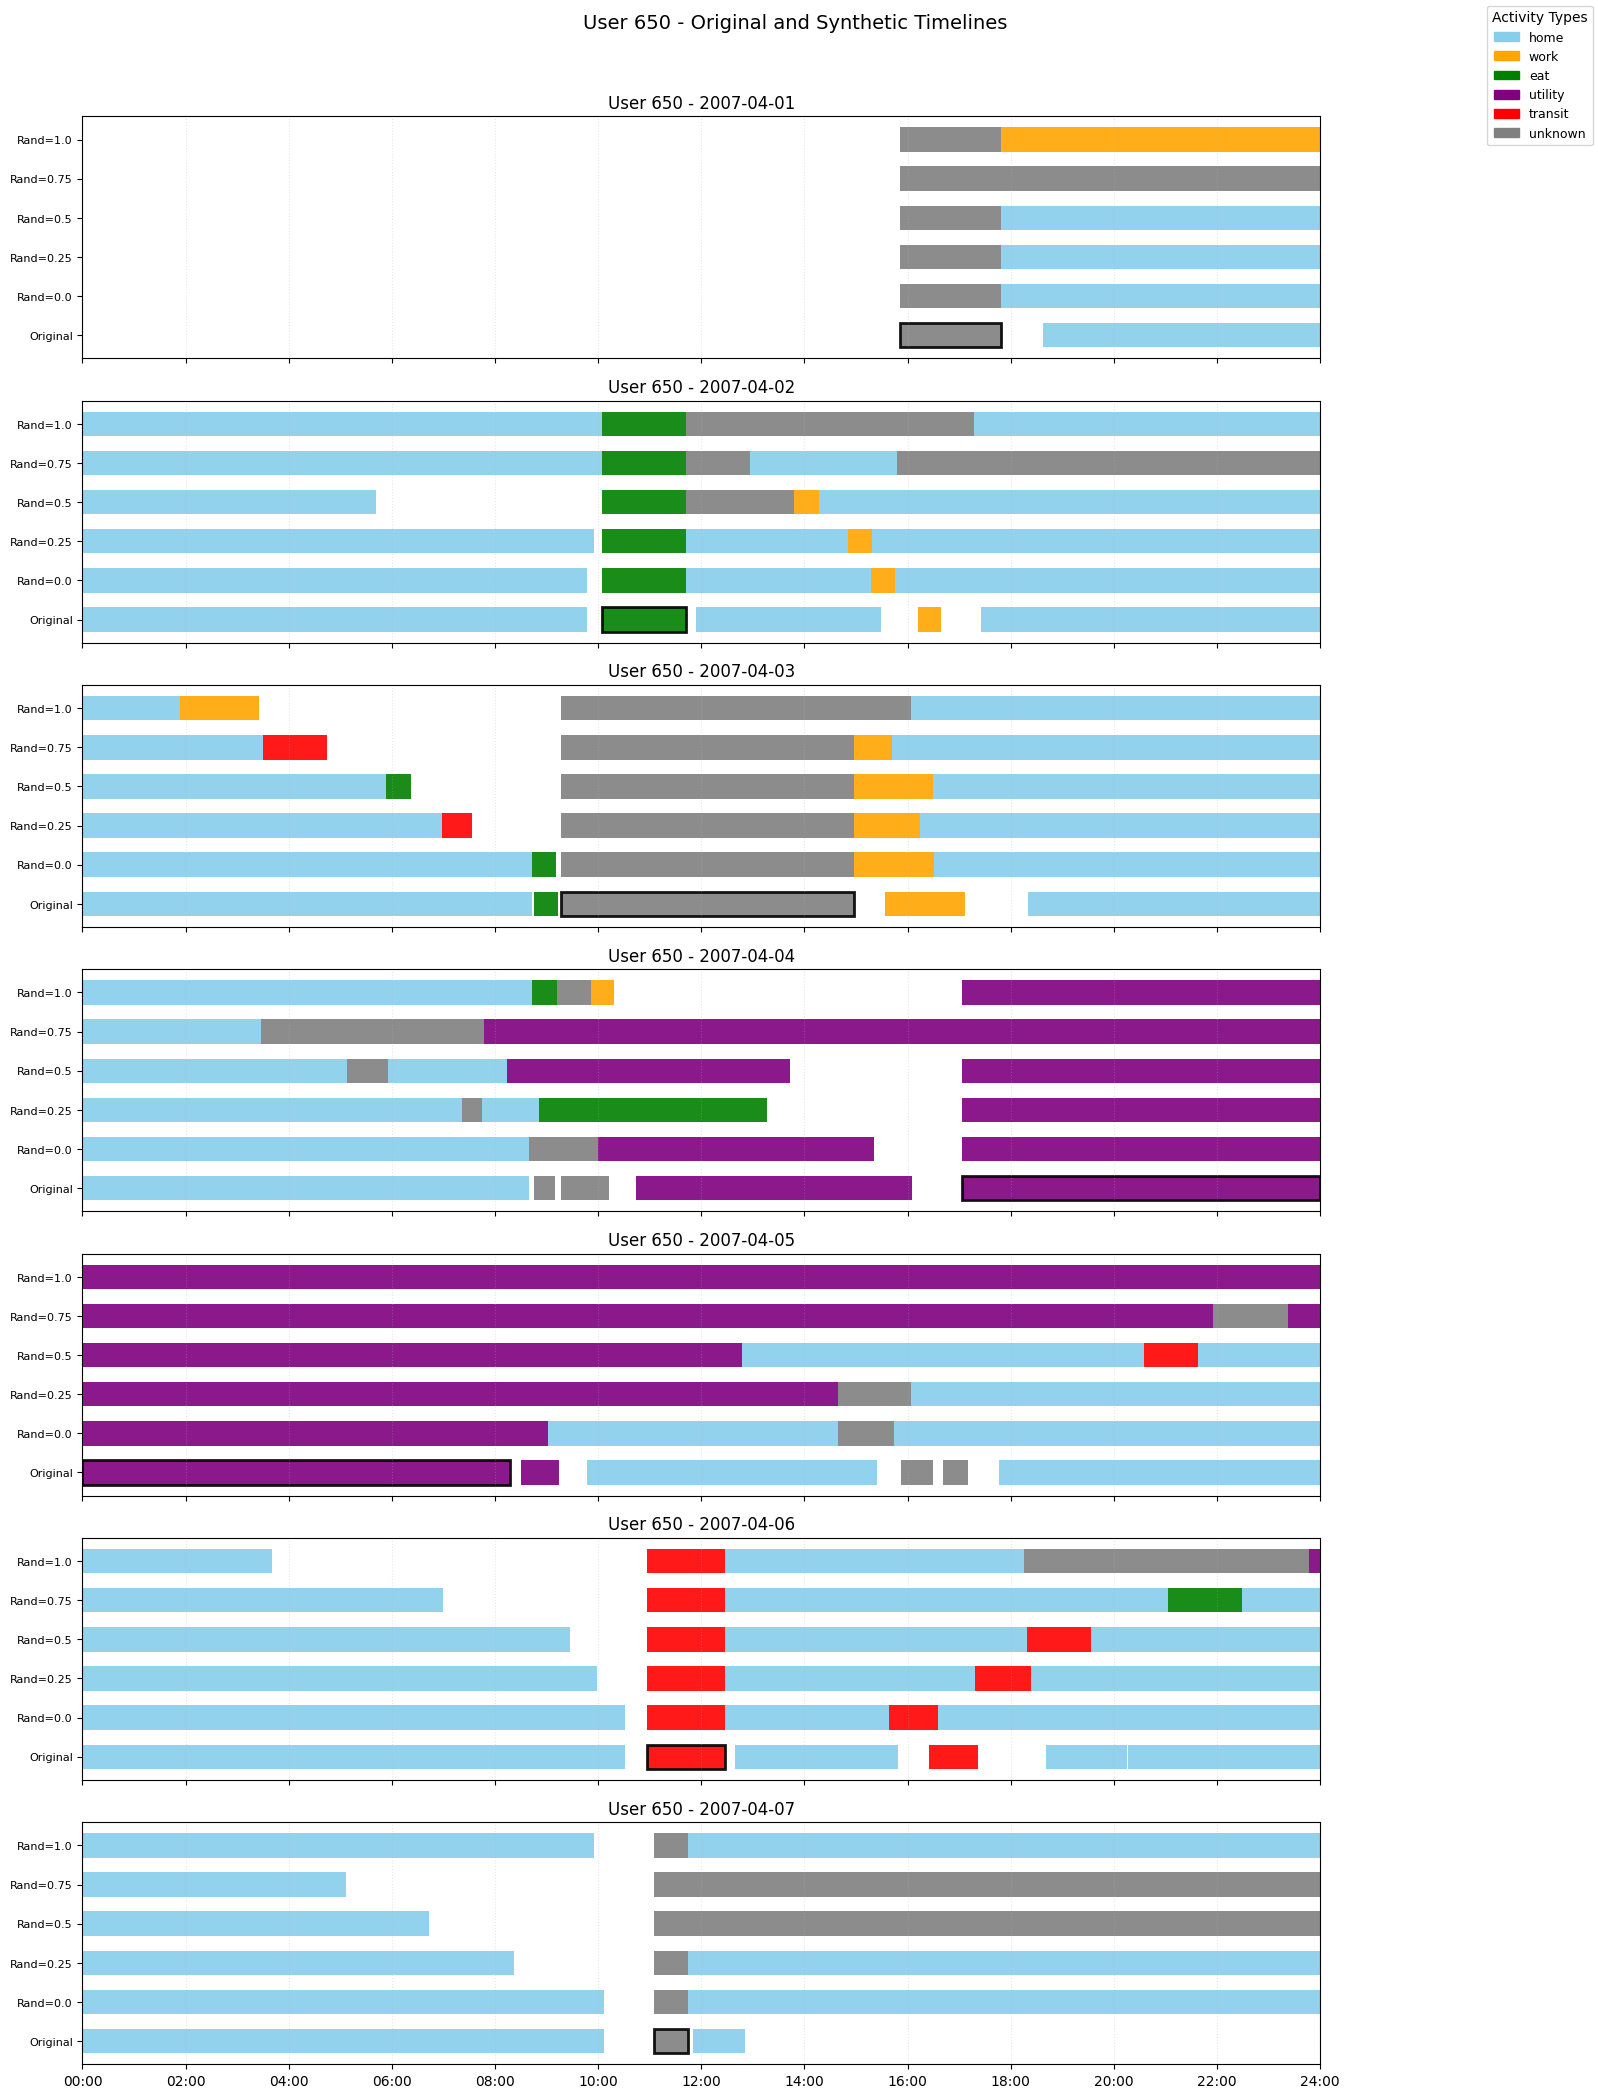

In [43]:
randomness_levels = [0.0, 0.25, 0.5, 0.75, 1.0]

# Step 1: prepare data
day_data = prepare_day_data(stays_by_day, user_duration_probs, user_transition_probs, randomness_levels, tz)

# Step 2: visualize
fig = visualize_day_data(day_data, user_id=user_id)
plt.show()
